# Time Series Analysis of Monterey Airport Weather Data

### Contents

1. [Setup](#setup)

I. ARIMA Models
2. [Exploring Stationarity](#stationarity)
3. [Autocorrelation and Partial Autocorrelation](#correlation)
4. [AR(1) Modeling](#ar)

II. Exponential Smoothing Models
5. [Naive Season-Trend-Level Decomposition](#naive)
6. [Holt-Winters Seasonal Smoothing](#holt-winters) (a. [Model Comparison](#comparison), b. [2019 Predictions](#forecast))

III. Experimental
7. [Exploring Cointegration](#cointegration)

<a id='setup'></a>

### 1. Setup

In [1]:
from datetime import datetime
from random import seed, random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
# pandas settings
pd.set_option('display.max_columns', 125) # csv contains 124 columns
pd.set_option('display.max_rows', 4000) # display more rows
pd.options.mode.chained_assignment = None  # turn off false positive warnings for editing a copy

In [3]:
df = pd.read_csv('cleaned_df.csv', parse_dates=['datetime'], index_col=['datetime'])
df.head()

,DATE,HourlySkyConditions,HourlyVisibility,HourlyDryBulbTemperature,HourlyWindSpeed,DailyMaximumDryBulbTemperature,DailyMinimumDryBulbTemperature,DailyPeakWindSpeed,DailyPrecipitation,HourlyRelativeHumidity,averageObscuration
datetime,,,,,,,,,,,
2009-04-01 00:08:00,2009-04-01T00:08:00,"[{'BKN': SkyCondition(obscuration=7, vertical_...",10.0,52.0,8.0,59.0,49.0,26.0,0.0,77.0,7.00000
2009-04-01 00:50:00,2009-04-01T00:50:00,"[{'SCT': SkyCondition(obscuration=4, vertical_...",9.0,52.0,10.0,59.0,49.0,26.0,0.0,77.0,4.00000
2009-04-01 00:54:00,2009-04-01T00:54:00,"[{'SCT': SkyCondition(obscuration=4, vertical_...",9.0,50.0,9.0,59.0,49.0,26.0,0.0,80.0,4.00000
2009-04-01 01:54:00,2009-04-01T01:54:00,[],9.0,51.0,10.0,59.0,49.0,26.0,0.0,77.0,4.91146
2009-04-01 02:54:00,2009-04-01T02:54:00,[],9.0,50.0,16.0,59.0,49.0,26.0,0.0,80.0,4.91146


## I. ARIMA Models

<a id='stationarity'></a>

### 2. Exploring Stationarity

We're primarily modeling the daily maximum temperature and daily average obscuration variables.

In [4]:
x = df
bool_index = (x.index.hour >= 10) & (x.index.hour <= 16) # consider the clearest and driest part of each day
x = x[bool_index]

obsc = x['averageObscuration'].resample(rule='D').mean().dropna()
hum = x['HourlyRelativeHumidity'].resample(rule='D').mean().dropna()
temp = x['DailyMaximumDryBulbTemperature'].resample(rule='D').last().dropna()

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


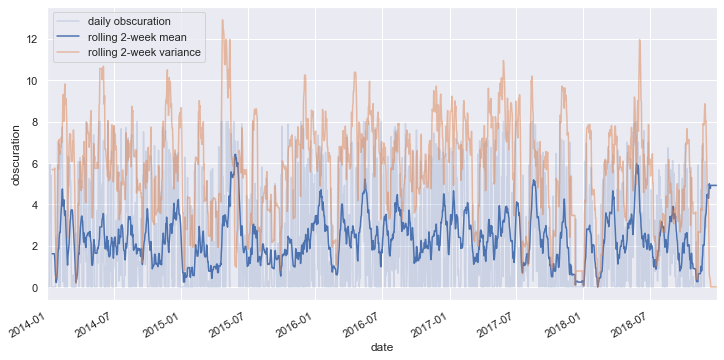

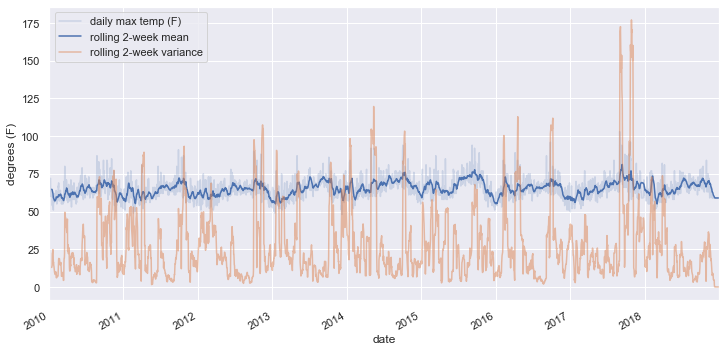

In [5]:
sns.set()



bool_index = (obsc.index.year >= 2014) & (obsc.index.year <= 2018)
obsc = obsc[bool_index]
bool_index = (temp.index.year >= 2010) & (temp.index.year <= 2018)
temp = temp[bool_index]

plt.figure(figsize=(12, 6))
plt.plot(obsc, color='b', alpha=0.2)
obsc.rolling(14).mean().plot()
obsc.rolling(14).var().plot(alpha=0.5)
plt.xlabel('date')
plt.ylabel('obscuration')
plt.legend(('daily obscuration', 'rolling 2-week mean', 'rolling 2-week variance'))
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(temp, color='b', alpha=0.2)
temp.rolling(14).mean().plot()
temp.rolling(14).var().plot(alpha=0.5)
plt.xlabel('date')
plt.ylabel('degrees (F)')
plt.legend(('daily max temp (F)', 'rolling 2-week mean', 'rolling 2-week variance'))



plt.show()

Does the Dickey-Fuller test think the daily average obscuration variable acts like a random walk? Its null hypothesis is that the series' properties (mean, variance, autocorrelation) change over time (the series is non-stationary).

In [6]:
results = adfuller(obsc)
print("p-value is:", results[1])

p-value is: 0.0


We can reject the null hypothesis that the daily average obscuration is non-stationary and have evidence to treat the series as stationary.

How about daily maximum temperature?

In [7]:
results = adfuller(temp)
print("p-value is:", results[1])

p-value is: 1.8819053175423097e-06


We can likewise reject the null hypothesis that the Daily Maximum temperature isn't stationary and can treat it as sa stationary series.

How about humidity?

In [8]:
# conduct test
results = adfuller(hum)
print("p-value is:", results[1])

p-value is: 0.0


The humidity is also likely a stationary time series.

In [9]:
# sanity check: does a random walk have a time dependent structure?

# Generate random residuals
np.random.seed(0)
errors = np.random.normal(0, 1, 1000)

# Create AR(1) (random walk) samples for models with and without unit roots
x_unit_root = [0]
x_no_unit_root = [0]
for i in range(len(errors)):
    x_unit_root.append(x_unit_root[-1] + errors[i])
    x_no_unit_root.append(0.9*x_no_unit_root[-1] + errors[i]) # (0.9 isn't 1, so no unit root)

# Calculate Augmented Dickey-Fuller p-values
adfuller(x_unit_root)[1], adfuller(x_no_unit_root)[1] # good: a random walk is non-stationary

(0.8925193132739655, 3.8562004970537815e-06)

<a id='correlation'></a>

### 3. Autocorrelation and Partial Autocorrelation

The autocorrelation and partial autocorrelation plots of the variables' lag difference series will help suggest the types of ARMA, ARIMA, or SARIMA models that might be appropriate for modeling the time series.

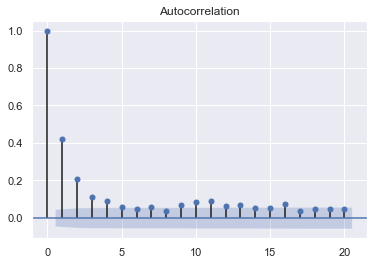

In [10]:
plot_acf(obsc, lags=20)
plt.show()

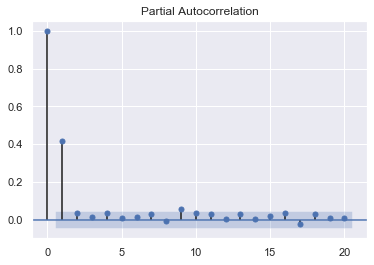

In [11]:
plot_pacf(obsc, lags=20)
plt.show()

Lags 1-4 show significant values in the auto-correlation plot, which suggests an AR model. The values' positive exponential decay suggests a positive value for $\phi$. The partial autocorrelation plot shows a significant value for lag one only, which suggests an AR(1) model.

How about the maximum daily temperature series?

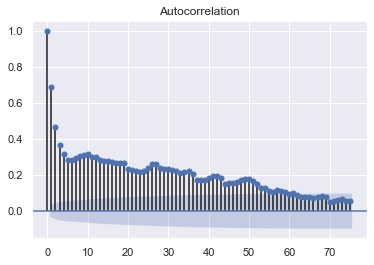

In [12]:
plot_acf(temp, lags=75)
plt.show()

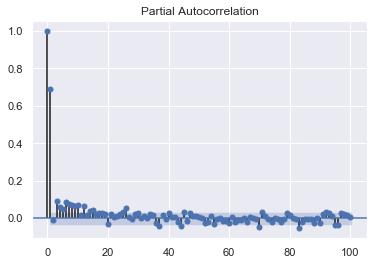

In [13]:
plot_pacf(temp, lags=100)
plt.show()

The temperature variable's partial autocorrelation also suggests an AR(1) model.

And humidity?

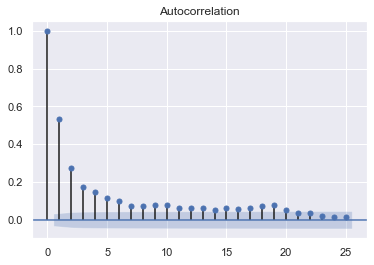

In [14]:
plot_acf(hum, lags=25)
plt.show()

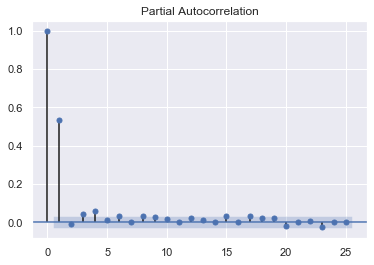

In [15]:
plot_pacf(hum, lags=25)
plt.show()

The humidity variable's partial autocorrelation also suggests an AR(1) model.

<a id='ar'></a>

### 4. AR(1) Modeling

In [29]:
def predict_next_value(future_steps):
    # Fit an AR(1) model to the first simulated data
    model = ARMA(temp, order=(1,0)) # fit to AR(1) model
    fitted = model.fit()

    # Print out summary information on the fit
    print(fitted.summary())

    # Print out the estimate for the constant and for phi
    print("The estimate of phi (and the constant) are:")
    print(fitted.params)

                                    ARMA Model Results                                    
Dep. Variable:     DailyMaximumDryBulbTemperature   No. Observations:                 3280
Model:                                 ARMA(1, 0)   Log Likelihood               -9818.798
Method:                                   css-mle   S.D. of innovations              4.828
Date:                            Wed, 03 Jul 2019   AIC                          19643.596
Time:                                    14:01:40   BIC                          19661.882
Sample:                                         0   HQIC                         19650.143
                                                                                          
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   65.2045      0.270    

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [28]:
len(temp)

3280

In [60]:
# forecast the past...
cast = fitted.predict(start='01-01-2019', end='12-31-2019')
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(temp)
plt.plot(cast)
plt.show()

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

### SARIMA (currently hangs computer)

In [49]:
# initialize models
sarima_model = SARIMAX(train, order=(0, 1, 0), seasonal_order=(1, 1, 0, 365), enforce_invertibility=False, enforce_stationarity=False)

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
# fit model to data (this cell takes a long time to run!)
sarima_fit = sarima_model.fit()

In [ ]:
# use model to forecast
sarima_pred = sarima_fit.get_prediction("01-01-2018", "12-31-2018")

In [ ]:
# calculate error
sse1 = np.sqrt(np.mean(np.square(test.values - sarima_pred.values)))

In [ ]:
# plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[-365:], train.values[-365:])
ax.plot(test.index, test.values, label='truth',color='b', alpha=.5);
ax.plot(test.index, sarima_pred, color='r', label="SARIMA Forecast (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, sarima_fit.aic))
ax.legend()
ax.set_xlabel('date')
ax.set_ylabel('degrees (F)')
ax.set_title("Yearly SARIMA (0,1,0)(1,1,0) Forecast")
plt.show()

## II. Exponential Smoothing Models

<a id='naive'></a>

### 5. Naive Season-Trend-Level Decomposition

Because the data aren't stationary, it's most appropriate to pursue exponential smoothing, rather than ARIMA approaches. The first approach will use a simple moving average technique.

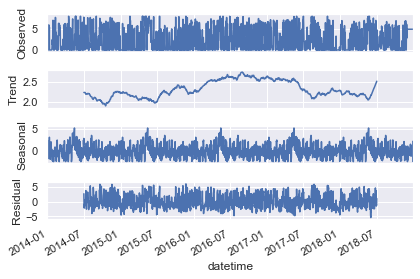

In [35]:
results = seasonal_decompose(obsc, model='additive', freq=365)
results.plot()
plt.show()

This approach identifies a stationary trend but non-stationary seasonal and residual components for both obscuration and max temperature, assuming an annual period.

In [103]:
df_results = adfuller(results.trend.dropna())
print("trend df p-value is:", df_results[1]) # trend is stationary

df_results = adfuller(results.seasonal.dropna())
print("seasonal df p-value is:", df_results[1]) # seasonality isn't

df_results = adfuller(results.resid.dropna())
print("residuals p-value is:", df_results[1]) # nor are residuals

trend df p-value is: 0.4488899725806956
seasonal df p-value is: 2.7805536590827702e-11
residuals p-value is: 0.0


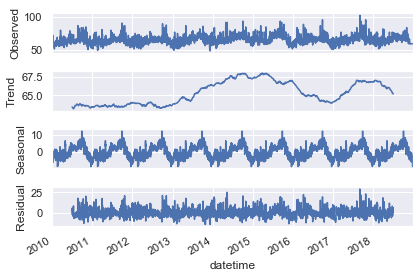

In [37]:
results = seasonal_decompose(temp, model='additive', freq=365)
results.plot()
plt.show()

In [105]:
df_results = adfuller(results.trend.dropna())
print("trend df p-value is:", df_results[1]) # trend is stationary

df_results = adfuller(results.seasonal.dropna())
print("seasonal df p-value is:", df_results[1]) # seasonality isn't

df_results = adfuller(results.resid.dropna())
print("residuals p-value is:", df_results[1]) # nor are residuals

trend df p-value is: 0.5280017871852764
seasonal df p-value is: 0.0001072283921320691
residuals p-value is: 0.0


<a id='holt-winters'></a>

### 6. Holt-Winters Seasonal Smoothing

<a id='comparison'></a>
#### 6a. Model Comparison

Next, we fit a Holt-Winters exponential smoothing model to the temperature data. We will use the Akaike Information Criterion to assess performance, and we will plot 2018 predictions over 2018's real values.

In [104]:
# separate data into train and test sets
train = temp[:-365]
test = temp.iloc[-365:]

In [105]:
# initialize models
model1 = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=365)
model2 = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=365, damped=True)
model3 = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=365, damped=True)

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [106]:
# fit models to data
fit1 = model1.fit()
cast1 = fit1.forecast(365)
fit2 = model2.fit()
cast2 = fit2.forecast(365)
fit3 = model3.fit()
cast3 = fit3.forecast(365)

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/trev7591a/.

In [107]:
# calculate error
sse1 = np.sqrt(np.mean(np.square(test.values - cast1.values)))
sse2 = np.sqrt(np.mean(np.square(test.values - cast2.values)))
sse3 = np.sqrt(np.mean(np.square(test.values - cast3.values)))

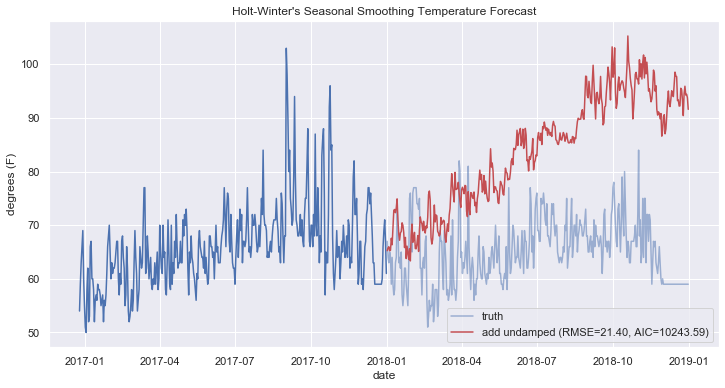

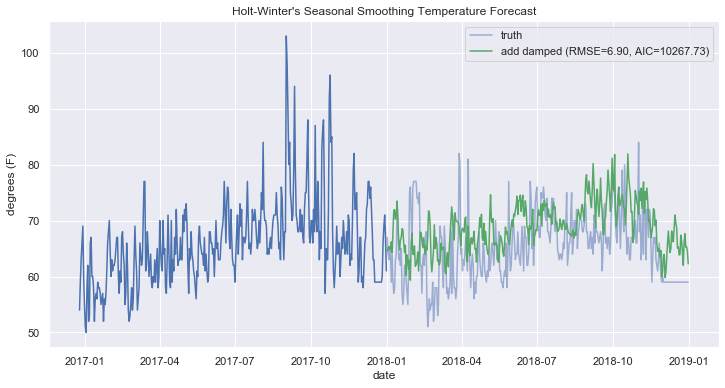

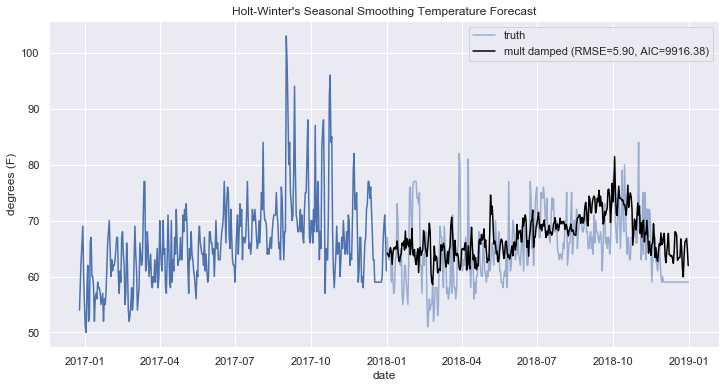

In [108]:
# plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[-365:], train.values[-365:])
ax.plot(test.index, test.values, label='truth',color='b', alpha=.5);
ax.plot(test.index, cast1, color='r', label="add undamped (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit1.aic));
ax.legend();
ax.set_xlabel('date')
ax.set_ylabel('degrees (F)')
ax.set_title("Holt-Winter's Seasonal Smoothing Temperature Forecast");
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[-365:], train.values[-365:])
ax.plot(test.index, test.values, label='truth',color='b', alpha=.5);
ax.plot(test.index, cast2, color='g', label="add damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse2, fit2.aic)); 
ax.legend();
ax.set_xlabel('date')
ax.set_ylabel('degrees (F)')
ax.set_title("Holt-Winter's Seasonal Smoothing Temperature Forecast");
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[-365:], train.values[-365:])
ax.plot(test.index, test.values, label='truth',color='b', alpha=.5);
ax.plot(test.index, cast3, color='black', label="mult damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse3, fit3.aic)); 
ax.legend();
ax.set_xlabel('date')
ax.set_ylabel('degrees (F)')
ax.set_title("Holt-Winter's Seasonal Smoothing Temperature Forecast");
plt.show()

The undamped additive model goes off the rails, and both damped models perform better. [As predicted by Hyndman and Athanasopoulos](https://otexts.com/fpp2/holt-winters.html), the model with damped trend and multiplicative seasonality performs the best by both error and AIC measures.

We repeat the same process for the obscuration data.

In [109]:
# separate data into train and test sets
train = obsc.iloc[:-365]
test = obsc.iloc[-365:]

In [110]:
# initialize models
model1 = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=365)
model2 = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=365, damped=True)

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [111]:
# fit models to data
fit1 = model1.fit()
cast1 = fit1.forecast(365)
cast1 = cast1 - cast1.min()

fit2 = model2.fit()
cast2 = fit2.forecast(365)
cast2 = cast2 - cast2.min()

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [112]:
# calculate error
sse1 = np.sqrt(np.mean(np.square(test.values - cast1.values)))
sse2 = np.sqrt(np.mean(np.square(test.values - cast2.values)))

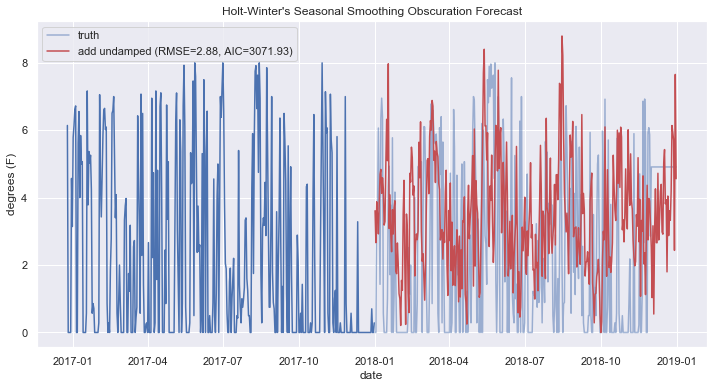

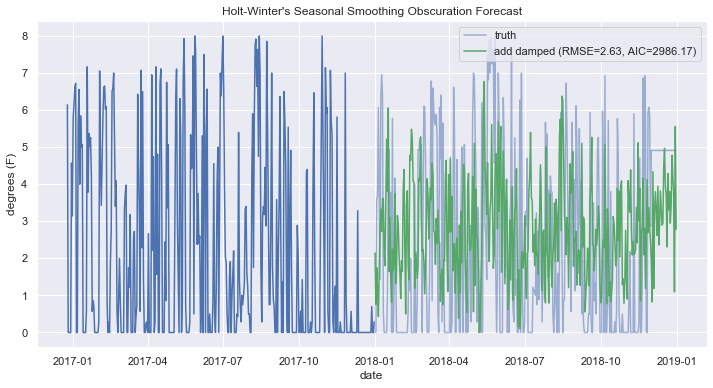

In [113]:
# plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[-365:], train.values[-365:])
ax.plot(test.index, test.values, label='truth',color='b', alpha=.5);
ax.plot(test.index, cast1, color='r', label="add undamped (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit1.aic));
ax.legend();
ax.set_xlabel('date')
ax.set_ylabel('degrees (F)')
ax.set_title("Holt-Winter's Seasonal Smoothing Obscuration Forecast");
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[-365:], train.values[-365:])
ax.plot(test.index, test.values, label='truth',color='b', alpha=.5);
ax.plot(test.index, cast2, color='g', label="add damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse2, fit2.aic)); 
ax.legend();
ax.set_xlabel('date')
ax.set_ylabel('degrees (F)')
ax.set_title("Holt-Winter's Seasonal Smoothing Obscuration Forecast");
plt.show()

For obscuration data, the performance difference between damped and undamped additive models  is much more ambiguous: the undamped model yielded less error, while the damped model yielded a lower AIC score. (All forecast values have been shifted up by their minimum value to avoid negative values.)

And we fit the same model to the humidity data:

In [114]:
# separate data into train and test sets
train = hum[:-365]
test = hum.iloc[-365:]

In [115]:
# initialize models
model1 = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=365)
model2 = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=365, damped=True)
model3 = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=365, damped=True)

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [116]:
# fit models to data
fit1 = model1.fit()
cast1 = fit1.forecast(365)
fit2 = model2.fit()
cast2 = fit2.forecast(365)
fit3 = model3.fit()
cast3 = fit3.forecast(365)

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/trev7591a/.

In [117]:
# calculate error
sse1 = np.sqrt(np.mean(np.square(test.values - cast1.values)))
sse2 = np.sqrt(np.mean(np.square(test.values - cast2.values)))
sse3 = np.sqrt(np.mean(np.square(test.values - cast3.values)))

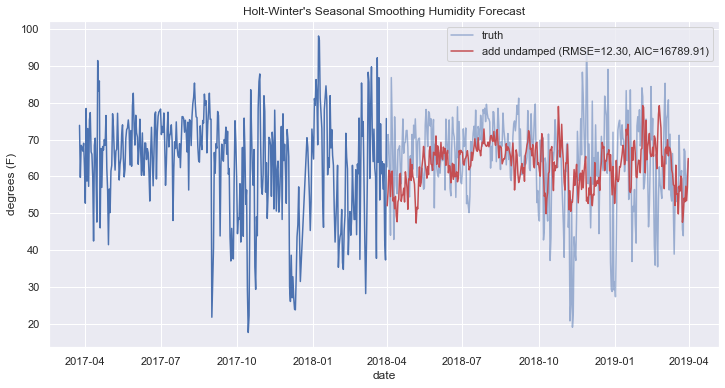

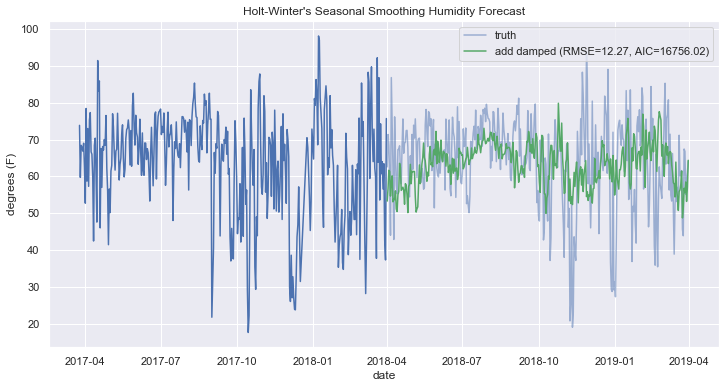

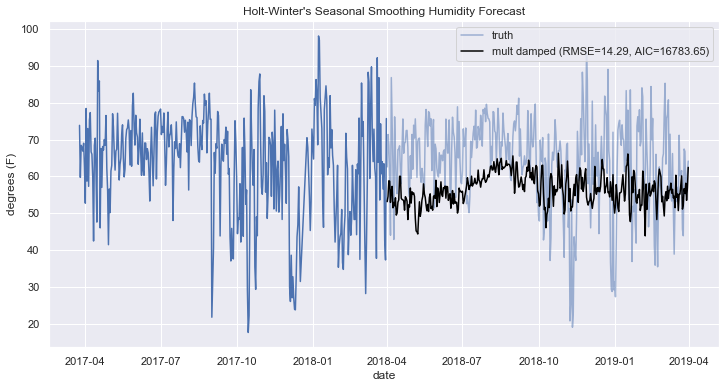

In [118]:
# plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[-365:], train.values[-365:])
ax.plot(test.index, test.values, label='truth',color='b', alpha=.5);
ax.plot(test.index, cast1, color='r', label="add undamped (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit1.aic));
ax.legend();
ax.set_xlabel('date')
ax.set_ylabel('degrees (F)')
ax.set_title("Holt-Winter's Seasonal Smoothing Humidity Forecast");
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[-365:], train.values[-365:])
ax.plot(test.index, test.values, label='truth',color='b', alpha=.5);
ax.plot(test.index, cast2, color='g', label="add damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse2, fit2.aic)); 
ax.legend();
ax.set_xlabel('date')
ax.set_ylabel('degrees (F)')
ax.set_title("Holt-Winter's Seasonal Smoothing Humidity Forecast");
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[-365:], train.values[-365:])
ax.plot(test.index, test.values, label='truth',color='b', alpha=.5);
ax.plot(test.index, cast3, color='black', label="mult damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse3, fit3.aic)); 
ax.legend();
ax.set_xlabel('date')
ax.set_ylabel('degrees (F)')
ax.set_title("Holt-Winter's Seasonal Smoothing Humidity Forecast");
plt.show()

In the case of the humidity data, the damped trend with additive trend and seasonality performs best by both error and AIC measures.

<a id='forecast'></a>
#### 6b. 2019 Model Predictions

In [164]:
# calculate index for use in all predictions
forecast_index = pd.date_range(start='01-01-2019', end='12-31-2019')

A damped, additive trend and multiplicative seaonality model predicts 2019 temperature data:

In [165]:
# set training data
train = temp

In [166]:
# initialize models
temp_model = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=365, damped=True)

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [167]:
# fit models to data
fit_temp = model3.fit()
temp_cast = fit_temp.forecast(365)

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


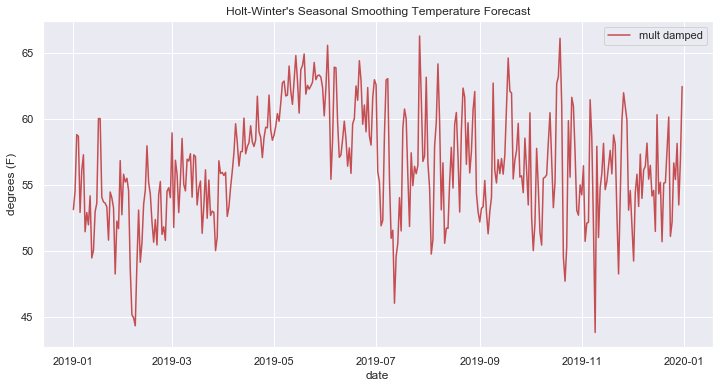

In [170]:
# plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(forecast_index, temp_cast, color='r', label="mult damped".format(sse1, fit1.aic));
ax.legend();
ax.set_xlabel('date')
ax.set_ylabel('degrees (F)')
ax.set_title("Holt-Winter's Seasonal Smoothing Temperature Forecast");
plt.show()

A damped, additive trend and additive seaonality model predicts 2019 obscuration data:

In [171]:
# set training data
train = obsc

In [172]:
# initialize model
model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=365, damped=True)

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [173]:
# fit models to data
obsc_fit = model.fit()
obsc_cast = obsc_fit.forecast(365)
obsc_cast = obsc_cast - obsc_cast.min()

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


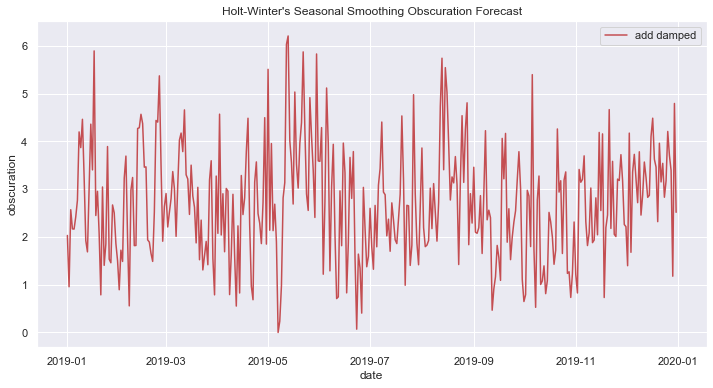

In [180]:
# plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(forecast_index, obsc_cast, color='r', label="add damped".format(sse1, fit1.aic));
ax.legend();
ax.set_xlabel('date')
ax.set_ylabel('obscuration')
ax.set_title("Holt-Winter's Seasonal Smoothing Obscuration Forecast");
plt.show()

A damped, additive trend and additive seaonality model predicts 2019 humidity data:

In [183]:
# set the training data
train = hum

In [184]:
# initialize models
model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=365, damped=True)

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [185]:
# fit models to data
fit = model.fit()
hum_cast = fit.forecast(365)

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


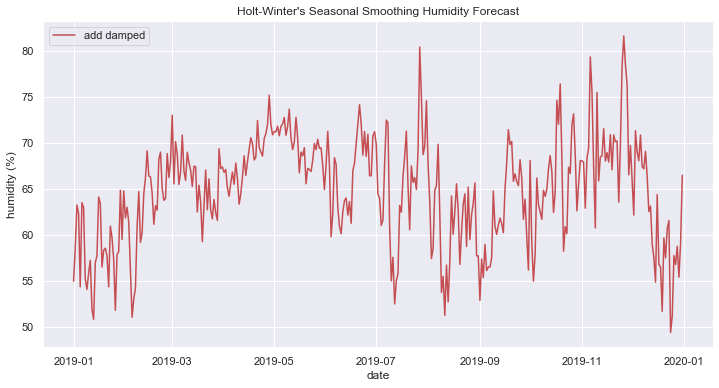

In [186]:
# plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(forecast_index, hum_cast, color='r', label="add damped");
ax.legend();
ax.set_xlabel('date')
ax.set_ylabel('humidity (%)')
ax.set_title("Holt-Winter's Seasonal Smoothing Humidity Forecast");
plt.show()

<a id='cointegration'></a>

### 7. Exploring Cointegration

Are linear combinations of any of these variables stationary? An augmented Engle-Granger two-step cointegration test will tell us. We assume the null hypothesis that the two variables aren't cointegrated:

In [122]:
x = df

temp = x['DailyMaximumDryBulbTemperature'].groupby(x.index.date).first().dropna()
obsc = x['averageObscuration'].groupby(x.index.date).mean().dropna()
hum = x['HourlyRelativeHumidity'].groupby(x.index.date).mean().dropna()

In [123]:
# coint(temp, obsc)
result = coint(temp, obsc)
print("p-value is:", result[1])

p-value is: 6.117418068893576e-05


Temperature and obscuration are significantly cointegrated.

In [124]:
result = coint(temp, hum)
print("p-value is:", result[1])

p-value is: 9.839466838683902e-05


...as are temperature and humidity...

In [127]:
result = coint(obsc, hum)
print("p-value is:", result[1])

p-value is: 0.007455394911557151


...as are obscuration and humidity.

Some visual investigation might provide more information.

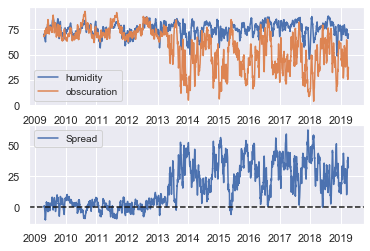

In [132]:

plt.subplot(2,1,1)
plt.plot(hum.rolling(14).mean(), label='humidity')
plt.plot((obsc/8.0 * 100).rolling(14).mean(), label='obscuration')
plt.legend(loc='best', fontsize='small')

# Plot the spread
plt.subplot(2,1,2)
plt.plot((hum - obsc/8.0 * 100).rolling(14).mean(), label='Spread')
plt.legend(loc='best', fontsize='small')
plt.axhline(y=0, linestyle='--', color='k')
plt.show()